<a href="https://colab.research.google.com/github/camdenmcgath/Artificial-Judge/blob/master/supreme_court_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import evaluate
import numpy as np
import transformers as trans
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, LongformerTokenizer, LongformerForSequenceClassification
import torch
from torch.optim import AdamW, lr_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import nltk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

import os
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2048"


In [2]:
cases = pd.read_csv("justice.csv")
cases.dropna(inplace=True)
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)

cases

,first_party,second_party,facts,facts_len,first_party_winner
1,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,True
2,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,True
3,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,True
4,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,True
5,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,True
...,...,...,...,...,...
3297,"Janet L. Yellen, Secretary of the Treasury",Confederated Tribes of the Chehalis Reservatio...,<p>For over a century after the Alaska Purchas...,2340,True
3298,United States,Refugio Palomar-Santiago,"<p>Refugio Palomar-Santiago, a Mexican nationa...",2054,True
3299,Tarahrick Terry,United States,<p>Tarahrick Terry pleaded guilty to one count...,1027,False
3300,United States,Joshua James Cooley,<p>Joshua James Cooley was parked in his picku...,1309,True


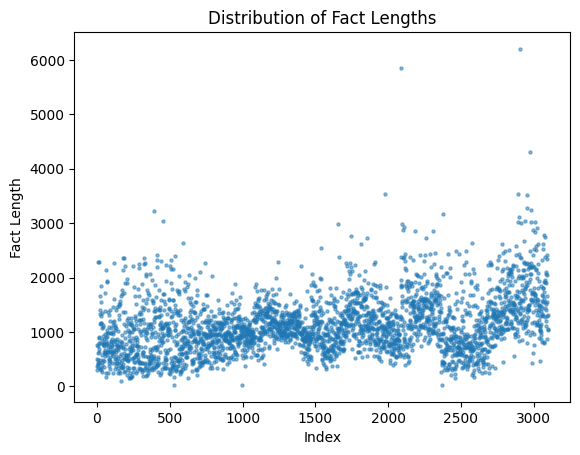

98.5474499677211


In [3]:
# Create a scatterplot of the fact lengths
plt.scatter(range(len(cases['facts_len'])), cases['facts_len'], s=5, alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')

plt.show()

# Count the number of facts below 2500 length
num_short_facts = len(cases[cases['facts_len'] < 2500])

# Calculate the percentage of short facts
percentage_short_facts = num_short_facts / len(cases) * 100
print(percentage_short_facts)

In [4]:
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        cases.loc[i, 'winning_party_idx'] = 0
    else:
        cases.loc[i, 'winning_party_idx'] = 1

In [5]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x)).apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

#cases['facts'] = cases['facts'].apply(remove_stopwords)


cases['token_facts'] = cases.apply(lambda x: f"{x['first_party']} [SEP] {x['second_party']} [SEP] {x['facts']}", axis=1)
cases = cases.drop(columns=['facts', 'first_party', 'second_party', 'facts_len'])

cases = cases.sample(frac=0.80, random_state=42)
train_facts, val_facts, train_winners,  val_winners = train_test_split(
    cases['token_facts'], cases['winning_party_idx'], test_size=0.25)

train_facts, val_facts = train_facts.tolist(), val_facts.tolist()
train_winners, val_winners = [str(i) for i in train_winners], [str(i) for i in train_winners]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        type(item)
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_facts, truncation=True, padding=True)
val_encodings = tokenizer(val_winners, truncation=True, padding=True)
train_dataset = TextDataset(train_encodings, train_winners)
val_dataset = TextDataset(val_encodings, val_winners)

type(train_dataset)


__main__.TextDataset

In [8]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir="test_trainer", 
    logging_dir='logs', 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    logging_steps=50,
)
#metric = evaluate.load("accuracy", "precision", "recall", "f1")
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

class CustomTrainer(Trainer):
  # Define custom loss function
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.643300,0.602948,0.000000


KeyboardInterrupt: ignored

In [ ]:
trainer.evaluate()